## Processing MoNuSAC challenge data for training a U-Net multi-class semantic segmentation model
Based on https://github.com/ruchikaverma-iitg/MoNuSAC

Reads .xml files and generate binary masks with labels from 0 (background) to 4 (according to `label_map`) below.

Binary masks will be saved in each sub-folder

* Folder -- Patient name
* Sub-folder -- images under each patient


In [1]:
label_map = {'Epithelial': 1, 
             'Lymphocyte': 2, 
             'Neutrophil': 3, 
             'Macrophage': 4}

In [2]:
#Process whole slide images
import os
import openslide
from xml.dom import minidom
import numpy as np
import openslide
from openslide import open_slide  
from glob import glob
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
import scipy
import scipy.ndimage
from shapely.geometry import Polygon
from skimage import draw
import xml.etree.ElementTree as ET
from tqdm import tqdm
import numpy as np

In [3]:
# Read svs files from the desired path
count = 0
data_path = '/data/datasets/MoNuSAC_images_and_annotations/' #Path to read data from
destination_path = '/data/datasets/' # Path to save n-ary masks corresponding to xml files
os.chdir(destination_path)

try:
    os.mkdir(destination_path+'MoNuSAC_bin_masks')
except OSError:
    print ("Creation of the mask directory %s failed" % destination_path)
    
os.chdir(destination_path+'MoNuSAC_bin_masks')#Create folder named as MoNuSAC_masks
patients = [x[0] for x in os.walk(data_path)]#Total patients in the data_path
patients = patients[1:]
len(patients)

46

In [4]:
images = []
masks = []
sizes_h = []
sizes_w = []

In [5]:
for patient_loc in tqdm(patients):
    patient_name = patient_loc[len(data_path):]#Patient name
    #print(f"patient {patient_name}")
    
    ## To make patient's name directory in the destination folder
    try:
        os.mkdir(patient_name)
    except OSError:
        print ("\n Creation of the patient's directory %s failed" % patient_name)
        
    ## Read sub-images of each patient in the data path        
    sub_images = glob(patient_loc+'/*.svs')
    for sub_image_loc in sub_images:
        images.append(sub_image_loc[sub_image_loc.find('TCGA'):-4]+'.tif')
        sub_image_name = sub_image_loc[len(data_path)+len(patient_name)+1:-4]        
        #print(f"image {sub_image_name}")
        
        ## To make sub_image directory under the patient's folder
        sub_image = './'+patient_name+'/'+sub_image_name #Destination path
            
        image_name = sub_image_loc
        img = openslide.OpenSlide(image_name)
                                  
        # If svs image needs to save in tif
        cv2.imwrite(sub_image_loc[:-4]+'.tif', np.array(img.read_region((0,0),0,img.level_dimensions[0])))      
   
        # Read xml file
        xml_file_name  = image_name[:-4]
        xml_file_name = xml_file_name+'.xml'
        tree = ET.parse(xml_file_name)
        root = tree.getroot()
        
        binary_mask = np.transpose(np.zeros((img.read_region((0,0),0,img.level_dimensions[0]).size))) 
        
        #Generate binary mask for each cell-type                         
        for k in range(len(root)):
            label = [x.attrib['Name'] for x in root[k][0]]
            label = label[0]
            #print(f"label: {label}")
            
            for child in root[k]:
                for x in child:
                    r = x.tag
                    if r == 'Attribute':
                        count = count+1
                        label = x.attrib['Name']
                                        
                    if r == 'Region':                        
                        regions = []
                        vertices = x[1]
                        coords = np.zeros((len(vertices), 2))
                        for i, vertex in enumerate(vertices):
                            coords[i][0] = vertex.attrib['X']
                            coords[i][1] = vertex.attrib['Y']        
                        regions.append(coords)
                        poly = Polygon(regions[0])  
                        
                        vertex_row_coords = regions[0][:,0]
                        vertex_col_coords = regions[0][:,1]
                        fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                        binary_mask[fill_row_coords, fill_col_coords] = label_map[label]
            #print(np.histogram(binary_mask))
            #print(np.unique(binary_mask))
            #plt.imshow(binary_mask)
            #plt.show()
        #print(np.unique(binary_mask))
        #plt.imshow(binary_mask)
        #plt.show()
        #print(sub_image)
        mask_path = f"{sub_image}_mask.png"
        cv2.imwrite(mask_path, binary_mask) 
        mask_path_npy = f"{sub_image}_mask.npy"
        np.save(file=mask_path_npy, arr=binary_mask)
        masks.append(mask_path_npy[mask_path_npy.find('TCGA'):])
        sizes_h.append(binary_mask.shape[0])
        sizes_w.append(binary_mask.shape[1])


100%|███████████████████████████████████████████| 46/46 [01:12<00:00,  1.58s/it]


In [6]:
assert len(images)==len(masks), 'all images should have a mask pair'

In [7]:
IMAGE_DIR = '/data/datasets/MoNuSAC_images_and_annotations/'
MASK_DIR = '/data/datasets/MoNuSAC_bin_masks/'

In [8]:
#from PIL import Image
sample_img = 102
img = cv2.imread(os.path.join(IMAGE_DIR, images[sample_img]))
mask = np.load(os.path.join(MASK_DIR, masks[sample_img]))

(788, 636, 3)


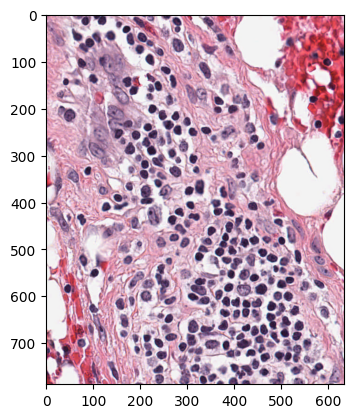

In [9]:
print(img.shape)
plt.imshow(img)

(788, 636)


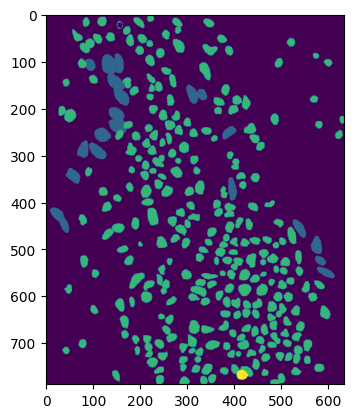

In [10]:
print(mask.shape)
plt.imshow(mask)

523.0


Text(0.5, 1.0, 'Distribution of Image width')

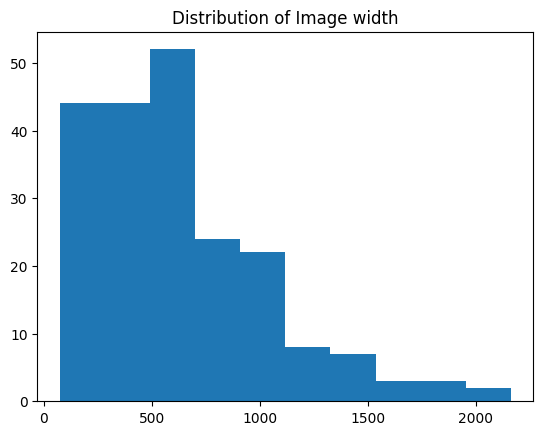

In [26]:
print(np.median(sizes_w))
plt.hist(sizes_w)
plt.title("Distribution of Image width")

In [13]:
MIN_SIZE = 160
images_crop = []
masks_crop = []

0it [00:00, ?it/s]

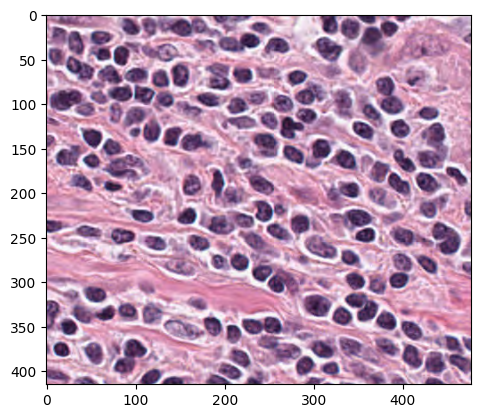

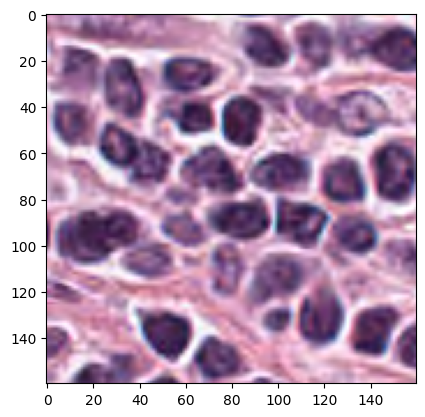

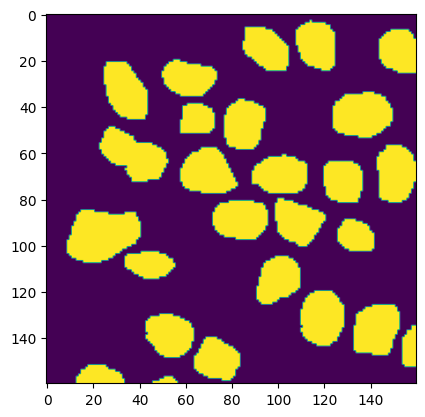

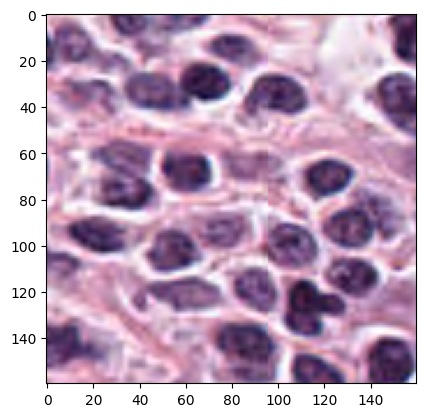

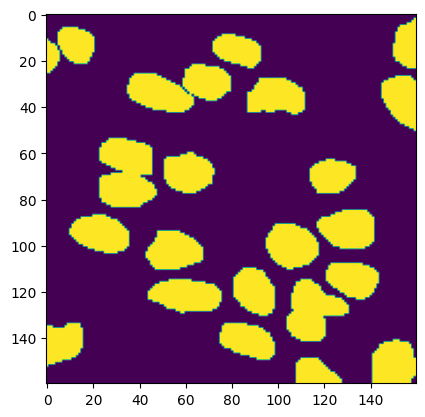

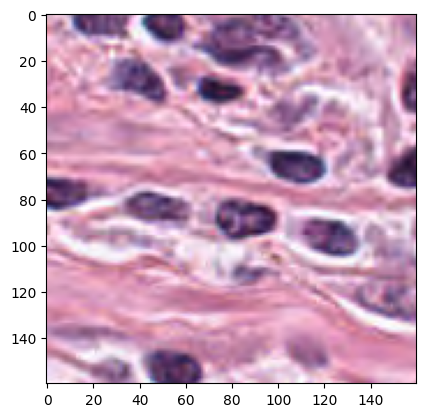

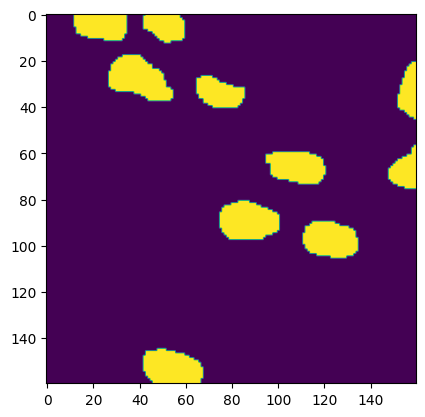

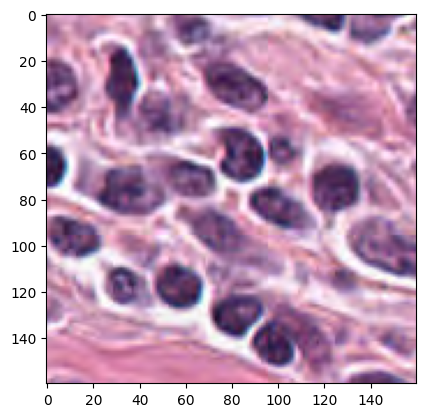

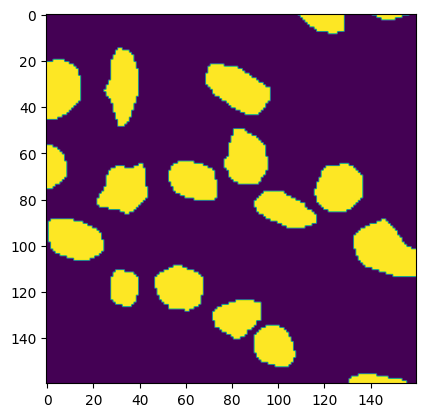

209it [00:15, 13.47it/s]


In [14]:
show_images = True


for image, mask in tqdm(zip(images, masks)):
    img = cv2.imread(os.path.join(IMAGE_DIR, image))
    msk = np.load(os.path.join(MASK_DIR, mask))
    if show_images:
        plt.imshow(img)
        plt.show()
    h, w = img[:,:,0].shape
    if h > MIN_SIZE*2:
        num_crops_h = h // MIN_SIZE
        num_crops_w = w // MIN_SIZE
        for i in range(num_crops_h):
            for j in range(num_crops_w):
                new_h = i*160
                new_w = j*160
                #print(new_h, new_h+MIN_SIZE, new_w, new_w+MIN_SIZE)
                crop_ij = img[new_h:new_h+MIN_SIZE,new_w:new_w+MIN_SIZE,:]
                crop_name = f"{image[:-4]}_{i}{j}.tif"
                images_crop.append(crop_name)
                cv2.imwrite(os.path.join(IMAGE_DIR,crop_name), crop_ij)      
                
                mask_ij = msk[new_h:new_h+MIN_SIZE,new_w:new_w+MIN_SIZE]
                mask_name = f"{mask[:-4]}_{i}{j}.npy"
                masks_crop.append(mask_name)
                np.save(file=os.path.join(MASK_DIR, mask_name), arr=mask_ij)
                if show_images:
                    plt.imshow(crop_ij)
                    plt.show()
                    plt.imshow(mask_ij)
                    plt.show()
    else:
        #just save image
        images_crop.append(image)
        masks_crop.append(mask)
    show_images = False
    

In [15]:
len(images_crop)

3225

In [16]:
len(masks_crop)

3225

In [17]:
assert len(images_crop)==len(masks_crop), 'all images should have a mask pair'

In [18]:
mask_ij.shape

(160, 160)

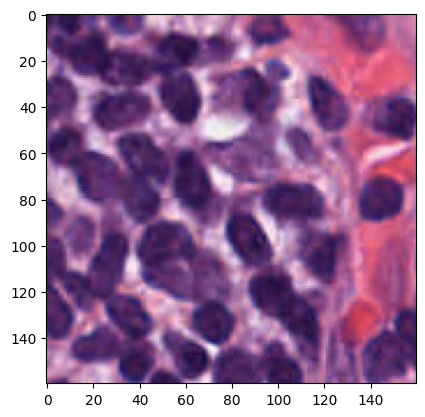

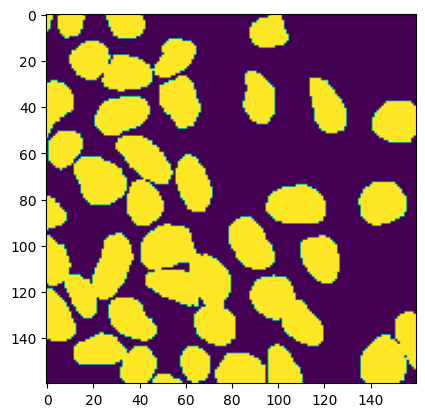

In [20]:
plt.imshow(crop_ij)
plt.show()
plt.imshow(mask_ij)
plt.show()

In [21]:
np.unique(mask_ij)

array([0., 2.])

### create json dataset

In [22]:
annotations = {'images': images_crop, 'masks': masks_crop}

In [23]:
import json
with open('/data/datasets/processed_dataset.json','w') as file:
    json.dump(annotations, file)